In [1]:
import re
from queue import Queue
from typing import Iterable
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from scipy.stats import entropy
from scipy import spatial

from Bio.Data import CodonTable
from mutspec_utils.constants import possible_sbs12

import warnings
warnings.filterwarnings("ignore")

# sns.set_style()

In [2]:
path_to_tree = "../data/example_nematoda/anc.treefile.rooted"
path_to_states = "../data/example_nematoda/nematoda_anc_mf/genes_states.tsv"
path_to_leaves = "../data/example_nematoda/leaves_states_nematoda.tsv"

In [3]:
tree = tree = PhyloTree(path_to_tree, format=1)

In [4]:
tree.describe()

Number of leaf nodes:	144
Total number of nodes:	287
Rooted:	Yes
Most distant node:	Meloidogyne_javanica
Max. distance:	4.701266


In [5]:
# print(tree.get_ascii())
# tree.show()

In [6]:
anc = pd.read_csv(path_to_states, sep="\t", comment='#',)
leaves = pd.read_csv(path_to_leaves, sep="\t")

states = pd.concat([anc, leaves]).sort_values(["Node", "Part", "Site"])
print(states.shape)
states.head()

(3616470, 8)


,Node,Part,Site,State,p_A,p_C,p_G,p_T
13068,Acanthocheilonema_viteae,1,1,-,0.0,0.0,0.0,0.0
13069,Acanthocheilonema_viteae,1,2,-,0.0,0.0,0.0,0.0
13070,Acanthocheilonema_viteae,1,3,-,0.0,0.0,0.0,0.0
13071,Acanthocheilonema_viteae,1,4,A,1.0,0.0,0.0,0.0
13072,Acanthocheilonema_viteae,1,5,T,0.0,0.0,0.0,1.0


In [7]:
anc[anc.Node == "Node6"]

,Node,Part,Site,State,p_A,p_C,p_G,p_T
1239210,Node6,1,1,A,0.55577,0.03441,0.17529,0.23454
1239211,Node6,1,2,T,0.10831,0.05473,0.07926,0.75771
1239212,Node6,1,3,A,0.55577,0.03441,0.17529,0.23454
1239213,Node6,1,4,T,0.03029,0.00379,0.00405,0.96187
1239214,Node6,1,5,T,0.00000,0.00002,0.00000,0.99998
...,...,...,...,...,...,...,...,...
1251850,Node6,12,683,G,0.23205,0.04658,0.45762,0.26374
1251851,Node6,12,684,T,0.12787,0.05944,0.09511,0.71758
1251852,Node6,12,685,T,0.12787,0.05944,0.09511,0.71758
1251853,Node6,12,686,T,0.12787,0.05944,0.09511,0.71758


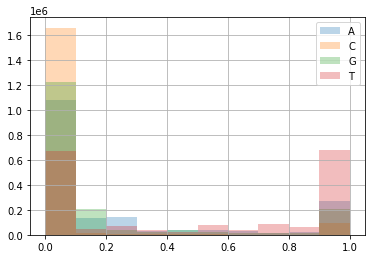

In [8]:
anc.p_A.hist(alpha=.3, label="A")
anc.p_C.hist(alpha=.3, label="C")
anc.p_G.hist(alpha=.3, label="G")
anc.p_T.hist(alpha=.3, label="T")
plt.legend()

## 21% of positions are uncertain

In [9]:
np.any(anc[["p_A", "p_C", "p_G", "p_T"]] > 0.8, 1).value_counts(normalize=True)

True     0.749697
False    0.250303
dtype: float64

In [10]:
sns.set_theme(style="white", palette='gist_gray')

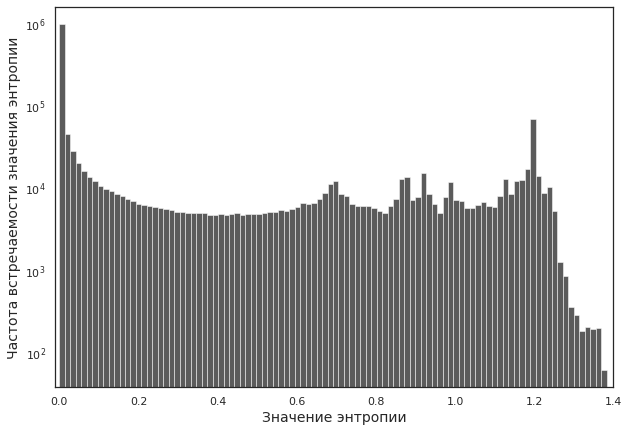

In [11]:
plt.figure(figsize=(10, 7))
mentr = entropy(anc[["p_A", "p_C", "p_G", "p_T"]], axis=1)
sns.histplot(mentr, bins=100)
# plt.title("Entropy");
plt.yscale("log")
plt.xlabel("Значение энтропии", fontsize=14)
plt.ylabel("Частота встречаемости значения энтропии", fontsize=14)
plt.xlim(-0.01, 1.40)
plt.savefig("../figures/nematoda_entropy.png")
plt.show()

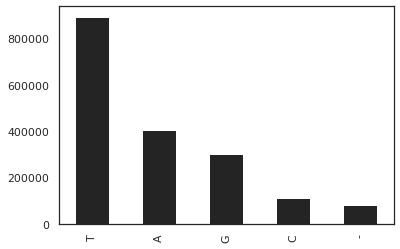

In [12]:
anc.State.value_counts().plot.bar();

## MUTSPEC

In [5]:
_path = "../data/processed/nematoda/09-06-22-19-08-04_anc_mf"

mutations = pd.read_csv(f"{_path}/mutations.tsv", sep="\t")
edge_mutspec12 = pd.read_csv(f"{_path}/mutspec12.tsv", sep="\t")
edge_mutspec12genes = pd.read_csv(f"{_path}/mutspec12genes.tsv", sep="\t")
freqs = pd.read_csv(f"{_path}/freqs.tsv", sep="\t")

edge_mutspec_all = edge_mutspec12[edge_mutspec12.Label == "all"]
edge_mutspec_syn = edge_mutspec12[edge_mutspec12.Label == "syn"]
edge_mutspec_ff  = edge_mutspec12[edge_mutspec12.Label == "ff"]

In [6]:
mutations

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene
0,T[T>A]T,0,53,2,TTT,TAT,F,Y,Node4,Node5,1
1,T[A>T]T,0,224,2,TAT,TTT,Y,F,Node4,Node5,1
2,A[G>A]T,1,396,3,GAG,GAA,E,E,Node4,Node5,1
3,A[C>T]T,0,401,2,ACT,ATT,T,I,Node4,Node5,1
4,T[C>T]T,0,464,2,TCT,TTT,S,F,Node4,Node5,1
...,...,...,...,...,...,...,...,...,...,...,...
95167,T[A>G]A,1,231,3,TTA,TTG,L,L,Node94,Cylicocyclus_ashworthi,12
95168,G[G>A]G,2,234,3,AGG,AGA,S,S,Node94,Cylicocyclus_ashworthi,12
95169,G[G>T]A,2,237,3,GGG,GGT,G,G,Node94,Cylicocyclus_ashworthi,12
95170,T[A>G]A,2,246,3,GTA,GTG,V,V,Node94,Cylicocyclus_ashworthi,12


In [7]:
# mutations.loc[(mutations.Label < 0) & (mutations.RefAa == "*"), "Label"] = -2

In [8]:
nonsense_muts = mutations[
    (mutations.Label < 0) & 
    (mutations.Mut.str.fullmatch("[ACGT]\[[ACGT]>[ACGT]\][ACGT]"))
]
nonsense_muts

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene
329,A[A>T]A,-2,81,3,TAA,TAT,*,Y,Node4,Node11,5
1161,T[T>A]A,-2,1699,1,TAA,AAA,*,K,Node3,Node2,11
1180,T[A>T]A,-1,148,1,AAA,TAA,K,*,Node5,Node6,1
1338,A[A>T]A,-2,81,3,TAA,TAT,*,Y,Node5,Node6,5
1683,A[T>G]A,-2,382,1,TAA,GAA,*,E,Node5,Node7,3
...,...,...,...,...,...,...,...,...,...,...,...
51043,T[A>T]A,-2,62,2,TAA,TTA,*,L,Node114,Cooperia_oncophora,9
58593,A[T>A]T,-1,72,3,TAT,TAA,Y,*,Node82,Node97,9
60626,A[A>C]C,-2,63,3,TAA,TAC,*,Y,Node115,Node116,9
67469,T[A>T]A,-2,71,2,TAA,TTA,*,L,Node97,Node98,9


In [9]:
from mutspec.annotation import mutations_summary

genes_order = "ATP6 ATP8 COX1 COX2 COX3 CYTB ND1 ND2 ND3 ND4 ND4L ND5".split()
genes_mapper = dict(zip(range(1, len(genes_order)+1), genes_order))
msumsary = mutations_summary(mutations, "Gene", None, genes_mapper)
msumsary["syn"] += msumsary["syn4f"]
msumsary.to_csv("../data/share/nematoda/summary_mutations.csv")
msumsary

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
ATP6,1621,3220,1575,3,1,0
ATP8,1975,11366,6154,2,0,0
COX1,1295,4634,2157,7,1,1
COX2,1711,5543,2802,4,1,0
COX3,2950,7648,3766,7,1,0
CYTB,2434,6025,2895,4,2,0
ND1,3557,4684,1791,6,3,0
ND2,1142,1950,802,0,0,0
ND3,3867,8183,3967,6,3,0


### (Unneeded) Translate MutSpec to heavy strand

(Genes are on Heavy strand, but sequenced Light strand equivalent - mRNA)

In [10]:
# transcriptor = str.maketrans("ACGT", "TGCA")


# def rev_comp(mut: str):
#     new_mut = mut[-1] + mut[1:-1] + mut[0]
#     new_mut = new_mut.translate(transcriptor)
#     return new_mut

In [11]:
# edge_mutspec12["Mut"] = edge_mutspec12["Mut"].str.translate(transcriptor)
# edge_mutspec12genes["Mut"] = edge_mutspec12genes["Mut"].str.translate(transcriptor)

# edge_mutspec_all["Mut"] = edge_mutspec_all["Mut"].str.translate(transcriptor)
# edge_mutspec_syn["Mut"] = edge_mutspec_syn["Mut"].str.translate(transcriptor)
# edge_mutspec_ff["Mut"] = edge_mutspec_ff["Mut"].str.translate(transcriptor)

### Plot mutations and MutSpec

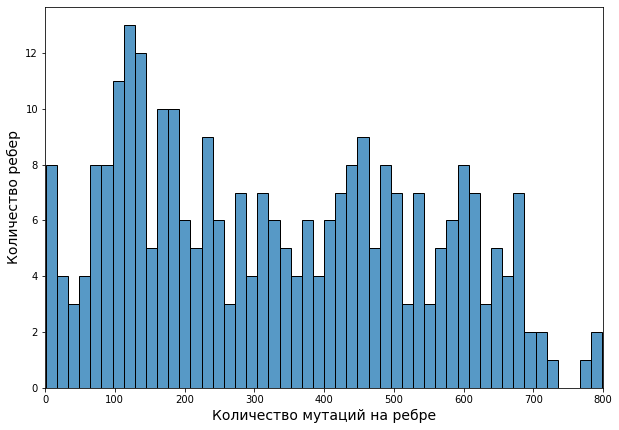

In [12]:
plt.figure(figsize=(10, 7))
sns.histplot(mutations.groupby("AltNode").apply(len), bins=50)
# plt.title("Distribution of edge mutation number")
plt.xlabel("Количество мутаций на ребре", fontsize=14)
plt.ylabel("Количество ребер", fontsize=14)
plt.xlim(0, 800)
plt.savefig("../figures/nematoda_edge_mut_count.png")
plt.show()

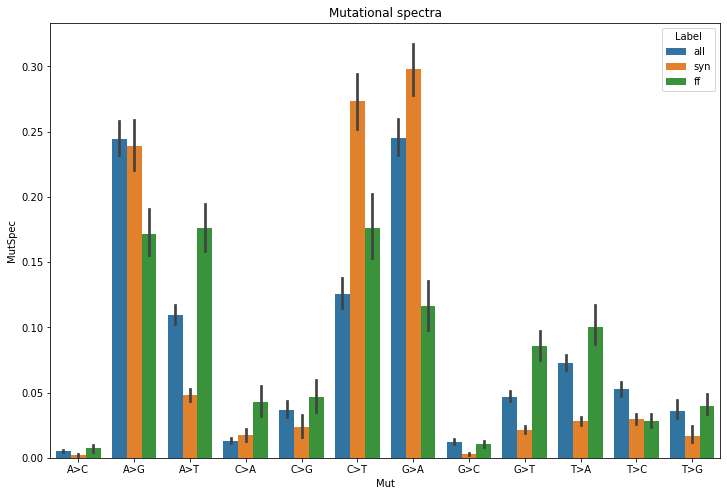

In [13]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Mut", y="MutSpec", hue="Label", data=edge_mutspec12, order=sorted(edge_mutspec12.Mut.unique()))
plt.title("Mutational spectra")
plt.show()

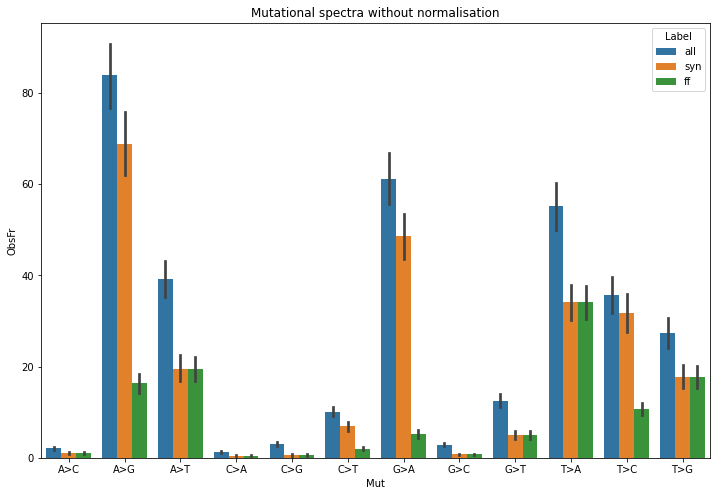

In [14]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Mut", y="ObsFr", hue="Label", data=edge_mutspec12, order=sorted(edge_mutspec12.Mut.unique()))
plt.title("Mutational spectra without normalisation")
plt.show()

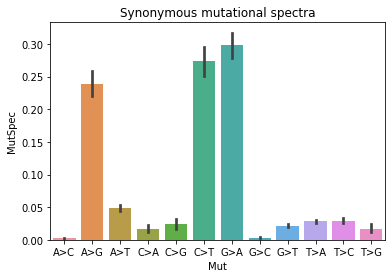

In [15]:
sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec_syn, order=sorted(edge_mutspec_syn.Mut.unique()));
plt.title("Synonymous mutational spectra")
plt.show()

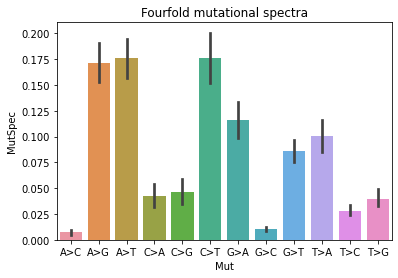

In [16]:
sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec_ff, order=sorted(edge_mutspec_ff.Mut.unique()));
plt.title("Fourfold mutational spectra")
plt.show()

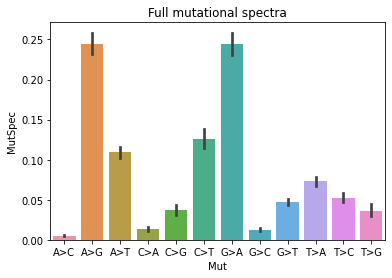

In [17]:
sns.barplot(x="Mut", y="MutSpec", data=edge_mutspec_all, order=sorted(edge_mutspec_all.Mut.unique()));
plt.title("Full mutational spectra")
plt.show()

### Prepare edge data for tree vizualisation

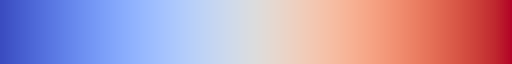

In [18]:
plt.cm.coolwarm

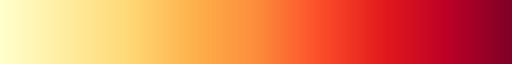

In [19]:
plt.cm.YlOrRd

In [20]:
[matplotlib.colors.to_hex(x) for x in plt.cm.coolwarm([.1, .3, .4, 1.])]

['#5977e3', '#9ebeff', '#c0d4f5', '#b40426']

In [21]:
def prepare_css_map(mutspec: pd.DataFrame, filename: str, sbs="C>T", cm=plt.cm.coolwarm, width=3, appendix=0.1):
    """
    stroke:green Individual Colobus Cercopithecus
    <br>
    stroke:#color Individual name1 name2 ...

    https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html

    http://gensoft.pasteur.fr/docs/newick-utils/1.6/nwutils_tutorial.pdf
    """
    assert bool(re.match("[ACGT]>[ACGT]", sbs)), f"sbs ({sbs}) is not appropriate"
    cols = ["RefNode", "AltNode", "MutSpec"]
    for c in cols:
        assert c in mutspec, f"Column {c} is not in mutspec dataframe"
    
    ms = mutspec[mutspec.Mut == sbs]

    handle = open(filename, "w")
    print(f"min: {ms.MutSpec.min():.2f}, max: {ms.MutSpec.max():.2f}")
    plt.hist(ms["MutSpec"], bins=20)
    plt.xlim(0, 0.9)
    plt.title(sbs)
    plt.show()
    colors = cm(ms["MutSpec"].values + appendix)
    for c, node in zip(colors, ms["AltNode"].values):
        chex = matplotlib.colors.to_hex(c)
        line = f"\"stroke:{chex}; stroke-width:{width}\" Individual {node}\n"
        handle.write(line)
    handle.close()

In [37]:
edge_mutspec_syn[edge_mutspec_syn.Mut == "C>T"]

,Mut,ObsFr,ExpFr,RawMutSpec,MutSpec,RefNode,AltNode,Label
18,C>T,1,20.0,0.050000,0.594733,Node4,Node5,syn
53,C>T,3,20.0,0.150000,0.597733,Node4,Node11,syn
93,C>T,0,23.0,0.000000,0.000000,Node3,Node27,syn
127,C>T,1,23.0,0.043478,0.272224,Node3,Node2,syn
160,C>T,3,24.0,0.125000,0.568459,Node5,Node6,syn
...,...,...,...,...,...,...,...,...
9989,C>T,31,105.0,0.295238,0.549137,Node92,Cylicocyclus_insigne,syn
10025,C>T,5,177.0,0.028249,0.271363,Node93,Node94,syn
10063,C>T,14,177.0,0.079096,0.228663,Node93,Cylicocyclus_nassatus,syn
10096,C>T,22,184.0,0.119565,0.329632,Node94,Cylicocyclus_radiatus,syn


A>C
min: 0.00, max: 0.19


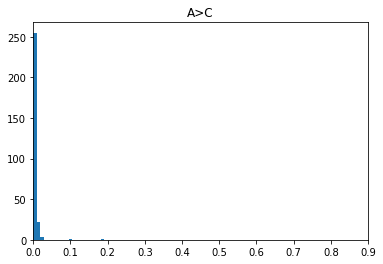

A>G
min: 0.00, max: 0.87


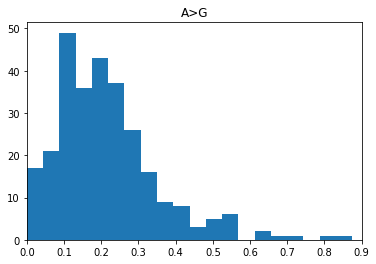

A>T
min: 0.00, max: 0.22


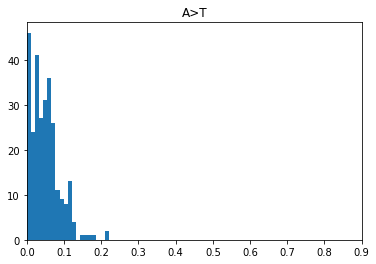

C>A
min: 0.00, max: 0.42


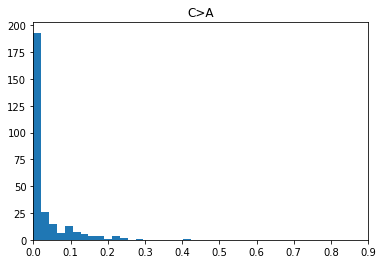

C>G
min: 0.00, max: 0.65


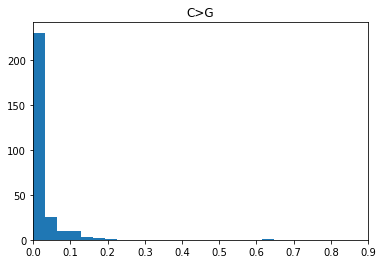

C>T
min: 0.00, max: 0.70


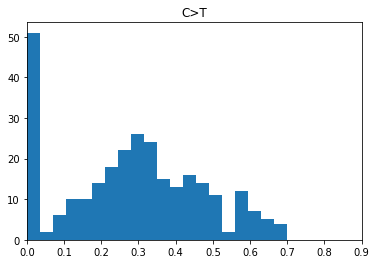

G>A
min: 0.00, max: 0.87


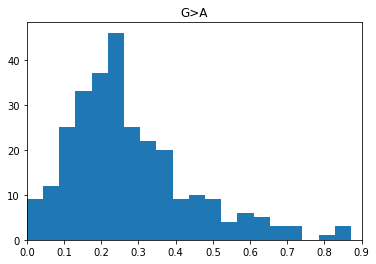

G>C
min: 0.00, max: 0.02


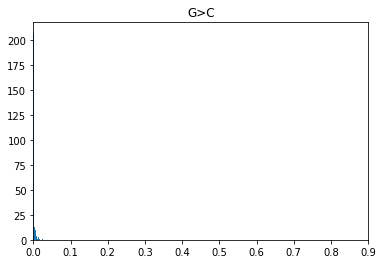

G>T
min: 0.00, max: 0.18


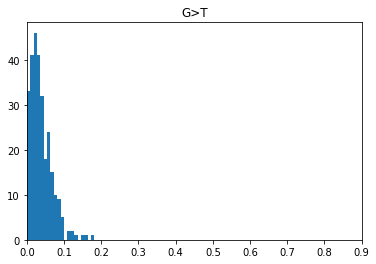

T>A
min: 0.00, max: 0.12


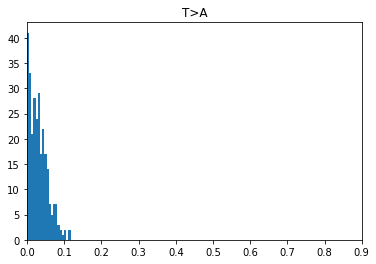

T>C
min: 0.00, max: 0.21


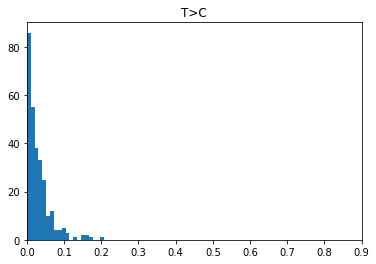

T>G
min: 0.00, max: 0.15


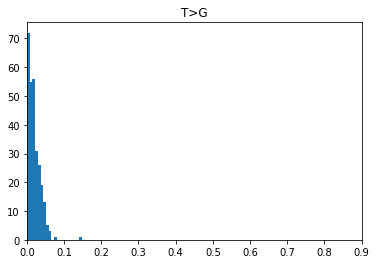

In [38]:
for sbs in possible_sbs12:
    print(sbs)
    prepare_css_map(edge_mutspec_syn, f"../data/share/nematoda/trees/style/{sbs}.css.map", sbs, plt.cm.YlOrRd)

In [39]:
# def prepare_one_mut_share_file(mutspec: pd.DataFrame, filename: str, sbs="C>T"):
#     assert bool(re.match("[ACGT]>[ACGT]", sbs)), "sbs is not appropriate"
#     cols = ["RefNode", "AltNode", "MutSpec"]
#     for c in cols:
#         assert c in mutspec, f"Column {c} is not in mutspec dataframe"
    
#     shares = mutspec[mutspec.Mut == sbs][cols]
#     shares.to_csv(filename, "\t", index=None)
#     return shares


In [23]:
# for sbs in possible_sbs12:
#     prepare_one_mut_share_file(
#         edge_mutspec12[edge_mutspec12.Label == "syn"], 
#         f"../data/share/{sbs}_edge_mutspec.tsv"
#     )

In [25]:
# edge_mutspec_ff[edge_mutspec_ff.Mut == "A>G"]["MutSpec"].hist();

### Grouping nodes on tree for everage mutspec

In [40]:
path_to_groups = "../data/example_nematoda/nematoda_groups.txt"

_collect_names = False
groups = defaultdict(list)
with open(path_to_groups) as fin:
    for line in fin:
        if line.endswith(")\n"):
            gr_num = int(line.strip(")\n"))
            _collect_names = True
        else:
            if len(line.strip()) == 0:
                _collect_names = False

            if _collect_names:
                name = line.strip().replace(" ", "_")
                groups[gr_num].append(name)


In [41]:
possible_sbs12 = sorted(edge_mutspec_all.Mut.unique())

In [42]:
all_nodes = set(edge_mutspec_all.AltNode)

for gr_num, gr in groups.items():
    for name in gr:
        if name not in all_nodes:
            print(gr_num, name)
print("All nodes found!")

All nodes found!


In [43]:
def get_joined_mutspec(edge_mutspec, groups, sim_cutoff=0.7):
    """ Join mutspec of edges by groups"""
    full_mutspec = []
    for lbl in edge_mutspec.Label.unique():
        print(f"\nLabel: {lbl}")
        edge_mutspec_lbl = edge_mutspec[edge_mutspec.Label == lbl]
        gr_mutspec = []
        for gr_num, gr in groups.items():
            pruned_tree = tree.copy()
            pruned_tree.prune(gr)
            assert len(pruned_tree) == len(gr)

            full_gr = [x.name for x in pruned_tree.iter_descendants()]
            gr_ms = edge_mutspec_lbl[edge_mutspec_lbl["AltNode"].isin(full_gr)]

            separated_ms = []
            for node in full_gr:
                sms = gr_ms[gr_ms["AltNode"] == node].sort_values("Mut")["MutSpec"].values
                separated_ms.append(sms)
            
            to_drop = []
            for sms1, node1 in zip(separated_ms, full_gr):
                one_sims = []
                for sms2, node2 in zip(separated_ms, full_gr):
                    if node1 == node2:
                        continue
                    sim = 1 - spatial.distance.cosine(sms1, sms2)
                    one_sims.append(sim)
                
                if np.mean(one_sims) < sim_cutoff:
                    print(f"group {gr_num}, {node1} - dropped with average similarity to other nodes {np.mean(one_sims):.2f}")
                    to_drop.append(node1)

            full_gr = set(full_gr).difference(to_drop)
            if len(full_gr) < 2:
                continue
            gr_ms = edge_mutspec_lbl[edge_mutspec_lbl["AltNode"].isin(full_gr)]
            gr_ms["Group"] = gr_num
            gr_mutspec.append(gr_ms)
        gr_mutspec_df = pd.concat(gr_mutspec)
        full_mutspec.append(gr_mutspec_df)
    full_mutspec_df = pd.concat(full_mutspec)
    return full_mutspec_df


In [44]:
gr_mutspec = get_joined_mutspec(edge_mutspec12, groups)


Label: all
group 5, Node125 - dropped with average similarity to other nodes 0.64
group 7, Node58 - dropped with average similarity to other nodes 0.70
group 7, Node59 - dropped with average similarity to other nodes 0.65
group 7, Node64 - dropped with average similarity to other nodes 0.70
group 7, Parascaris_equorum - dropped with average similarity to other nodes 0.69
group 7, Parascaris_univalens - dropped with average similarity to other nodes 0.47
group 15, Meloidogyne_javanica - dropped with average similarity to other nodes 0.70

Label: syn
group 1, Node85 - dropped with average similarity to other nodes 0.65
group 1, Node87 - dropped with average similarity to other nodes 0.66
group 1, Node88 - dropped with average similarity to other nodes 0.62
group 2, Node98 - dropped with average similarity to other nodes 0.67
group 2, Node99 - dropped with average similarity to other nodes 0.69
group 3, Node111 - dropped with average similarity to other nodes 0.67
group 3, Node113 - drop

In [45]:
# mean_mutspec_all = edge_mutspec_all.groupby("Mut").MutSpec.mean().sort_index()
# print("All")
# print("Group\tSimilarity to mean tree MutSpec")
# for gr_num in gr_mutspec_all:
#     ms = gr_mutspec_all[gr_num].sort_values("Mut").MutSpec
#     if len(ms) == 12:
#         sim = 1 - spatial.distance.cosine(ms, mean_mutspec_all)
#         print(f"{gr_num}\t{sim:.2f}")

In [46]:
# mean_mutspec_syn = edge_mutspec_syn.groupby("Mut").MutSpec.mean().sort_index()
# print("Syn")
# print("Group\tSimilarity to mean tree MutSpec")
# for gr_num in gr_mutspec_syn:
#     ms = gr_mutspec_syn[gr_num].sort_values("Mut").MutSpec
#     if len(ms) == 12:
#         sim = 1 - spatial.distance.cosine(ms, mean_mutspec_syn)
#         print(f"{gr_num}\t{sim:.2f}")

In [47]:
# mean_mutspec_ff = edge_mutspec_ff.groupby("Mut").MutSpec.mean().sort_index()
# print("Fourfold")
# print("Group\tSimilarity to mean tree MutSpec")
# for gr_num in gr_mutspec_ff:
#     ms = gr_mutspec_ff[gr_num].sort_values("Mut").MutSpec
#     if len(ms) == 12:
#         sim = 1 - spatial.distance.cosine(ms, mean_mutspec_ff)
#         print(f"{gr_num}\t{sim:.2f}")

### Group-specific mutational spectra plots

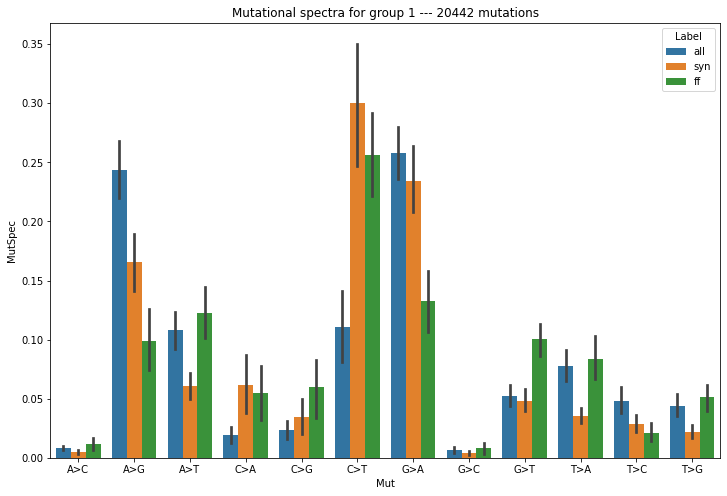

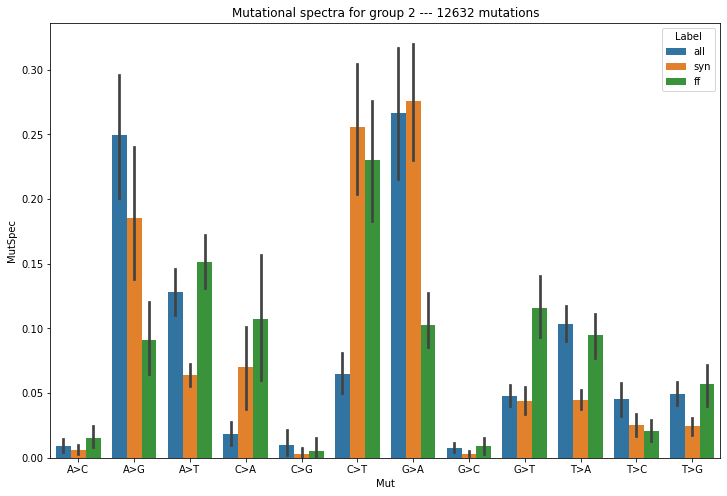

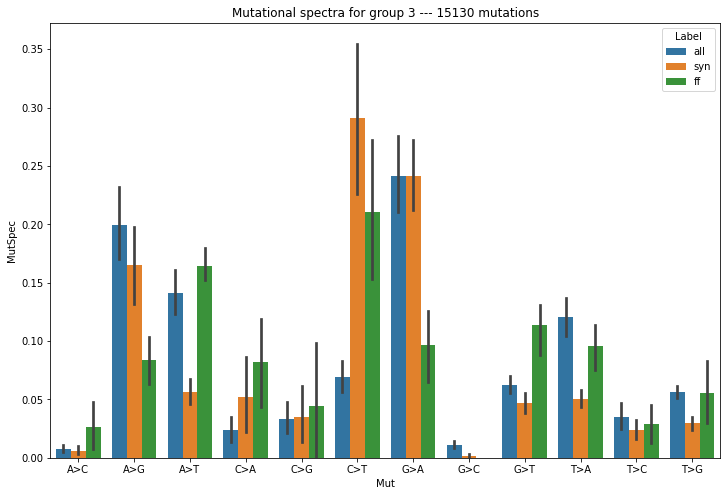

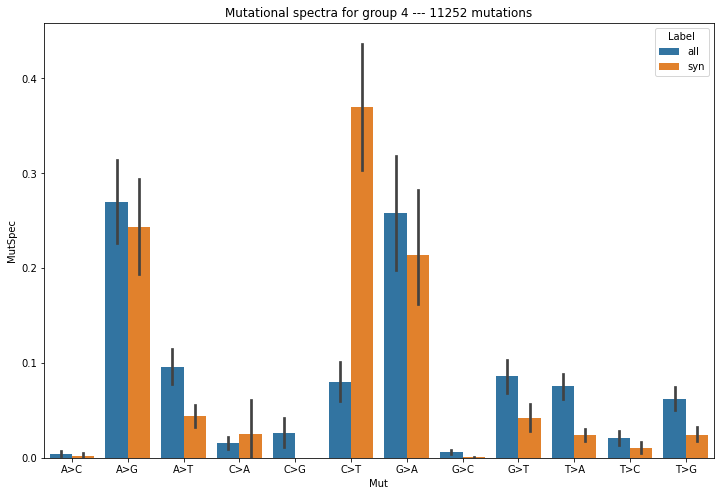

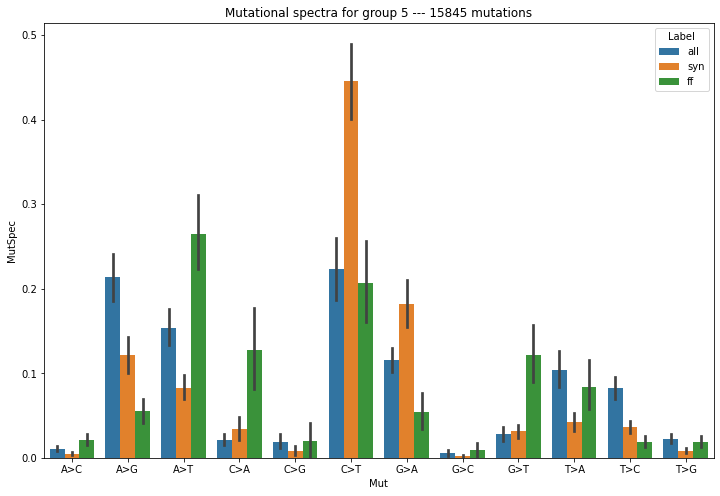

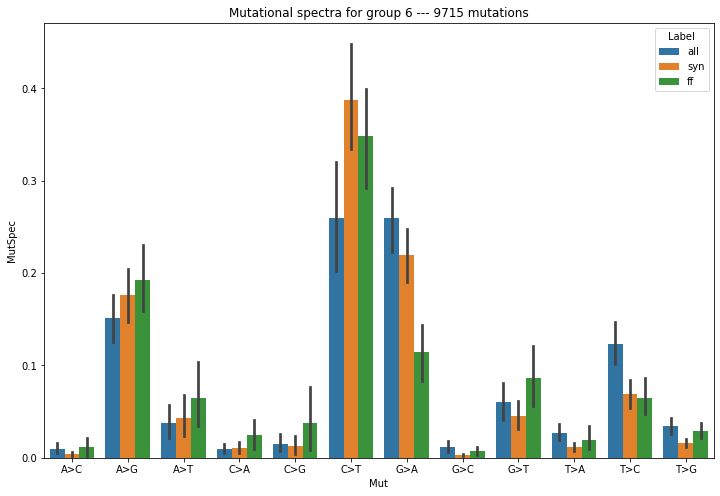

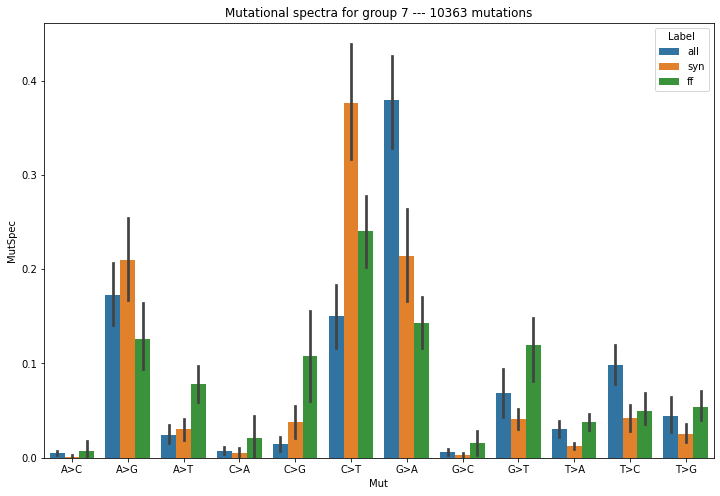

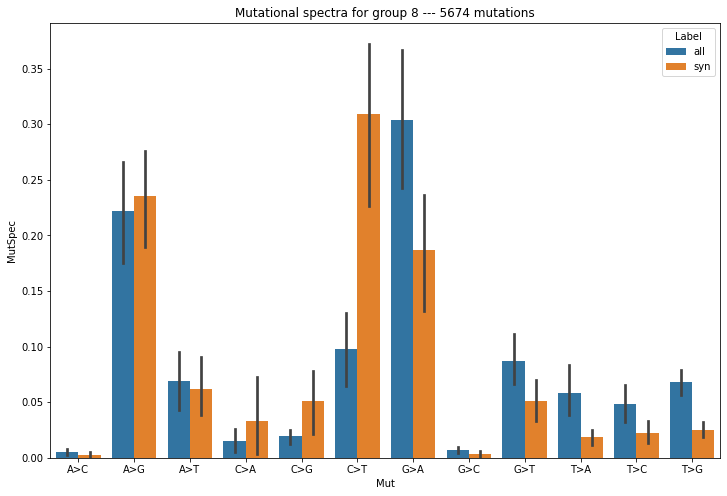

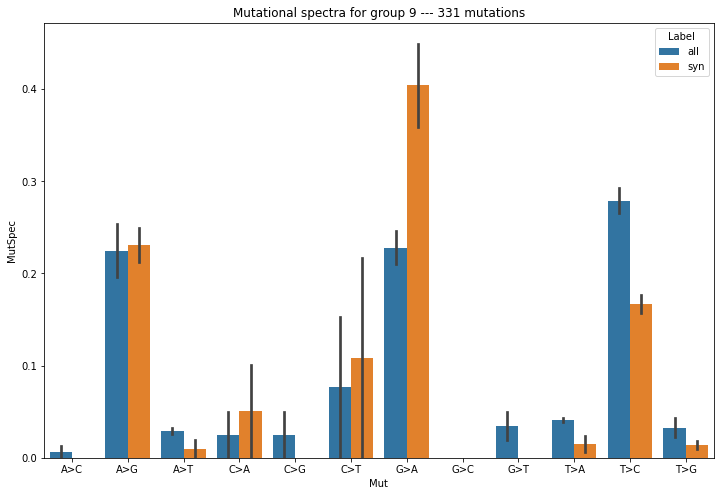

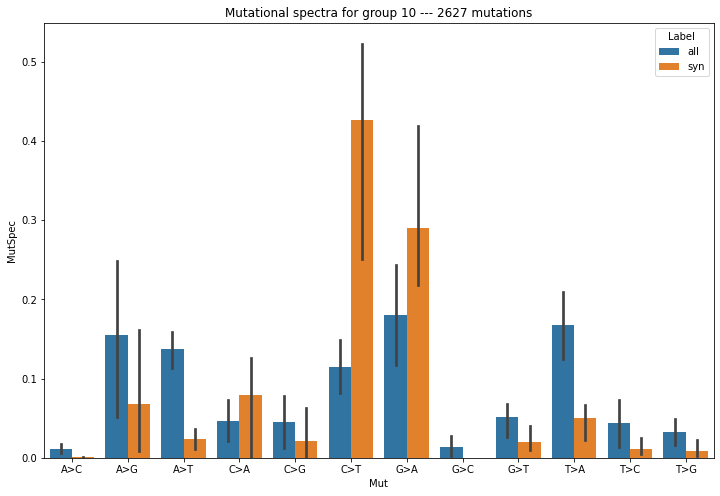

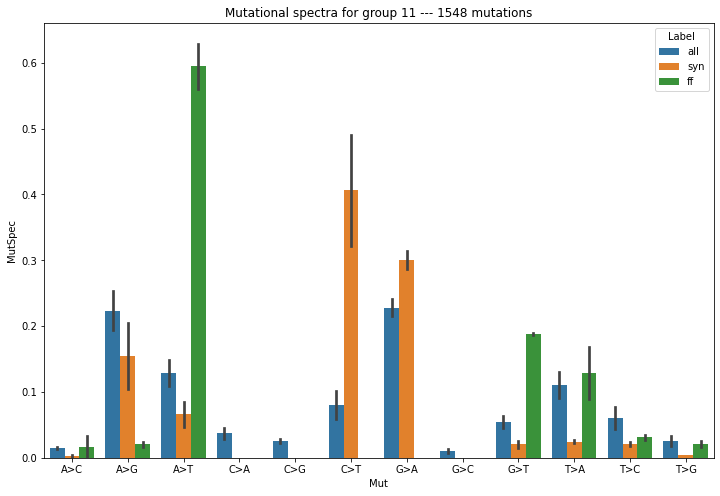

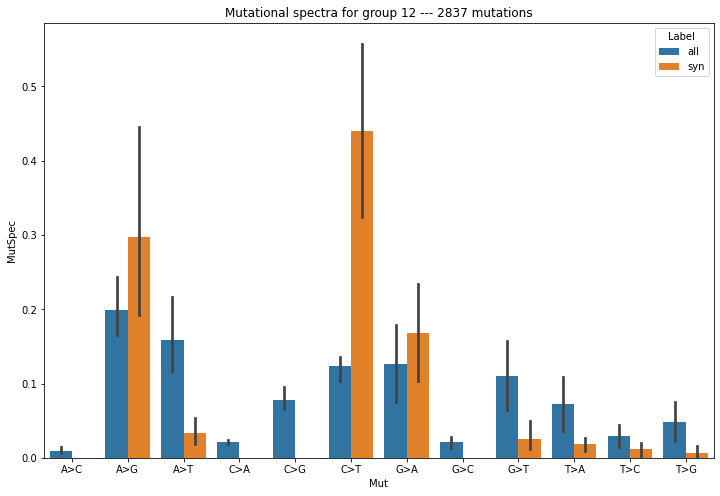

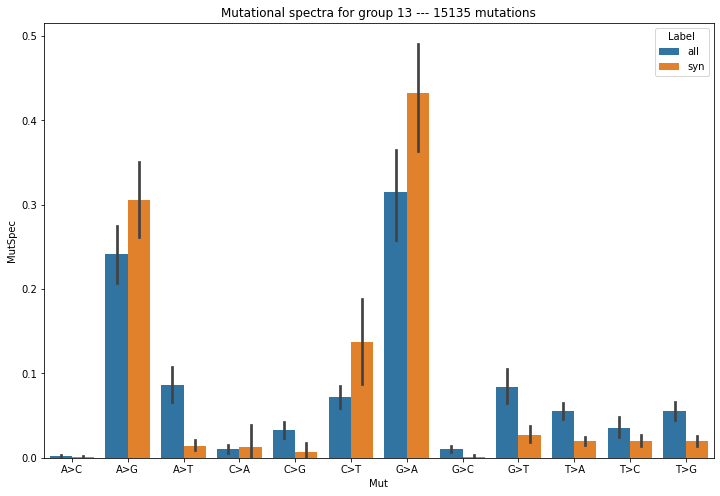

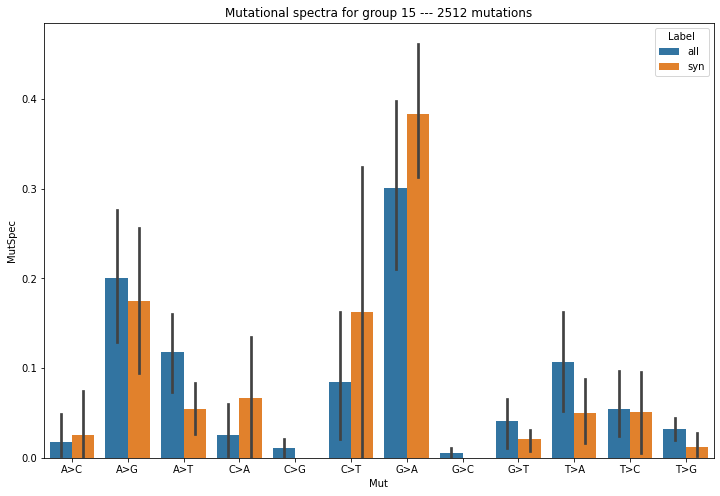

In [48]:
for gr_num in gr_mutspec.Group.unique():
    ms = gr_mutspec[gr_mutspec.Group == gr_num]
    mut_num = ms.ObsFr.sum()
    if mut_num > 50:
        plt.figure(figsize=(12, 8))
        sns.barplot(x="Mut", y="MutSpec", hue="Label", data=ms, order=possible_sbs12)
        plt.title(f"Mutational spectra for group {gr_num} --- {mut_num} mutations")
        plt.show()

### Genes mutspec
["ATP6", "COX1", "COX2", "COX3", "CYTB", "ND1", "ND2", "ND3", "ND4", "ND4L", "ND5", "ND6"]

In [49]:
id2gene = dict(zip(range(1, 13), ["ATP6", "COX1", "COX2", "COX3", "CYTB", "ND1", "ND2", "ND3", "ND4", "ND4L", "ND5", "ND6"]))

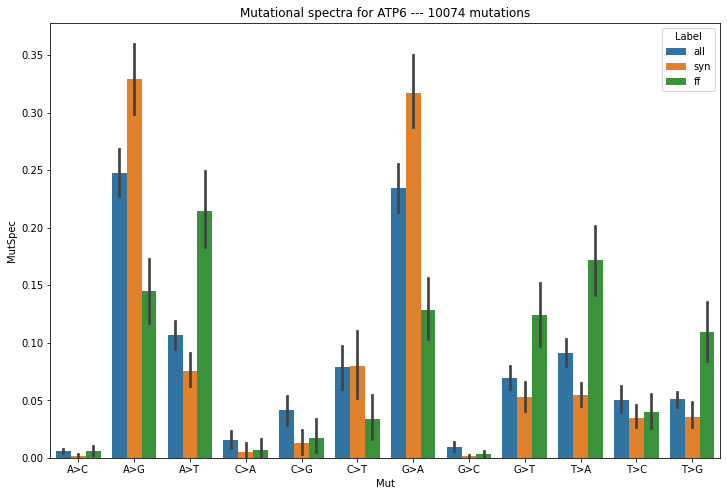

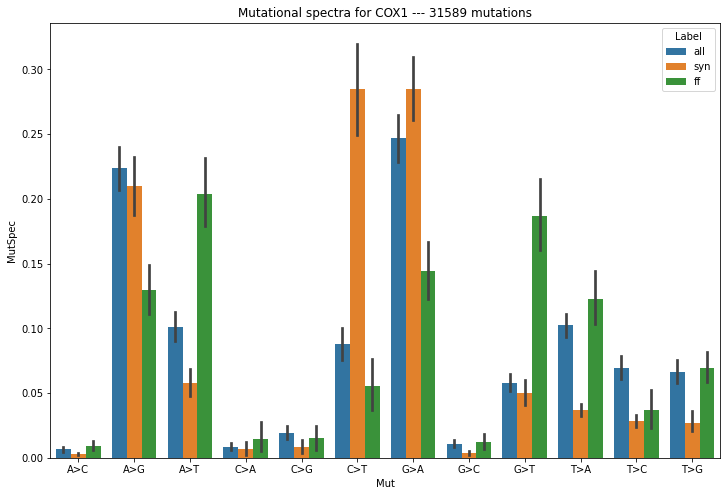

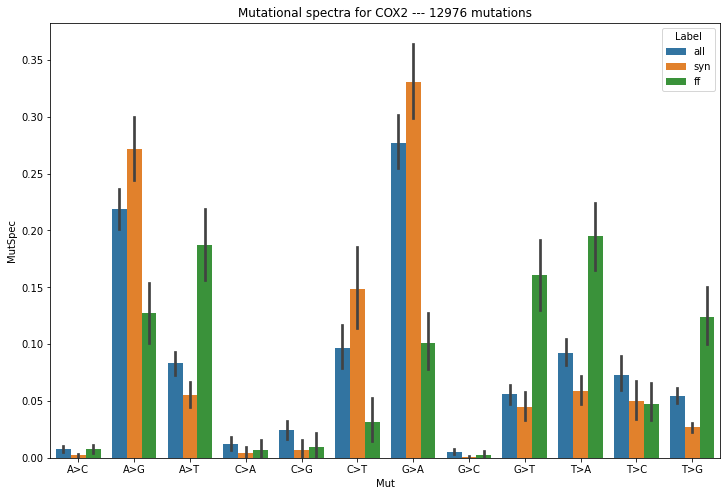

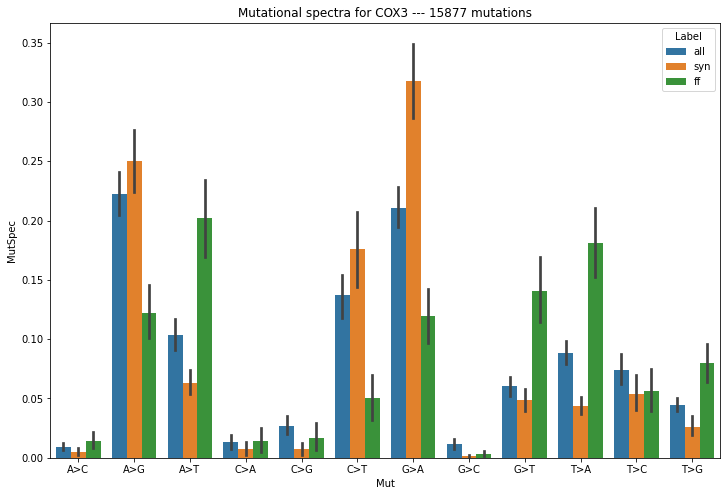

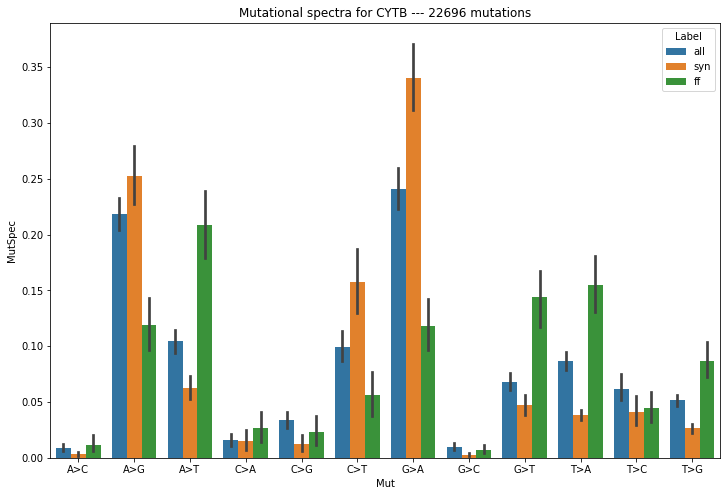

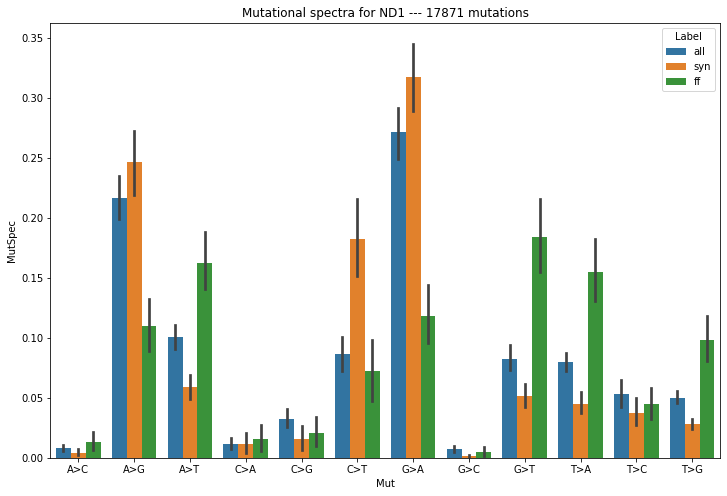

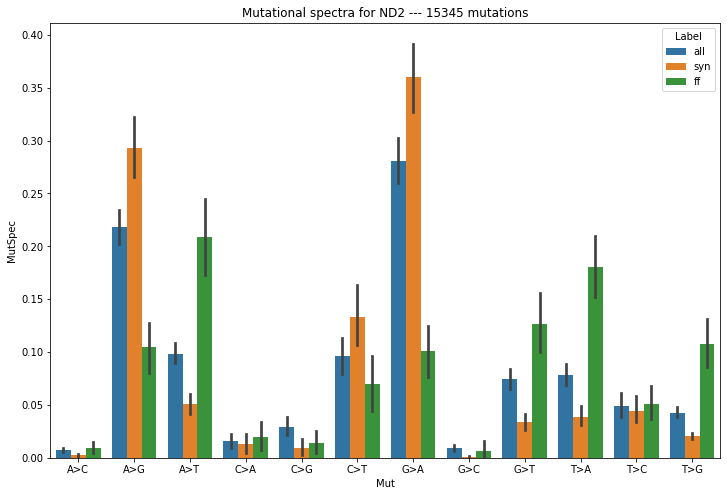

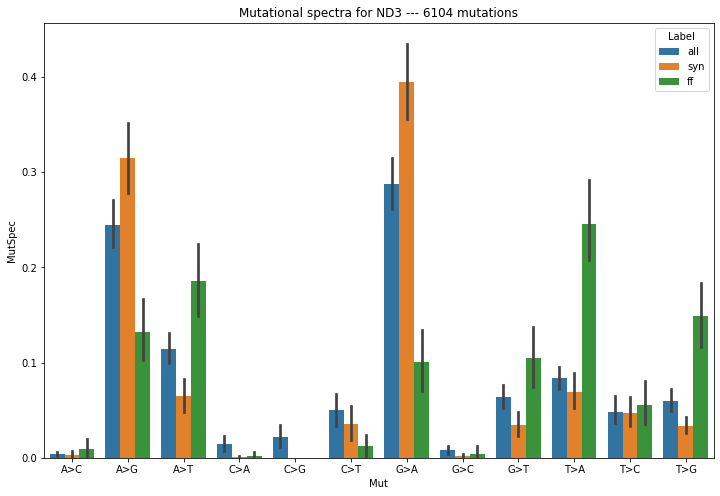

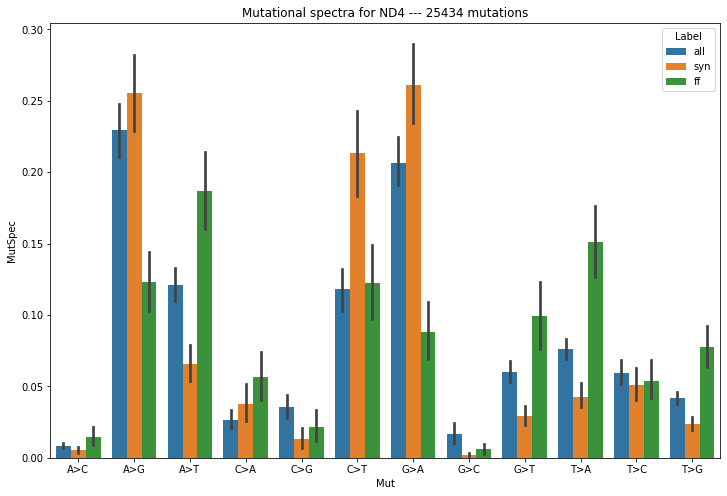

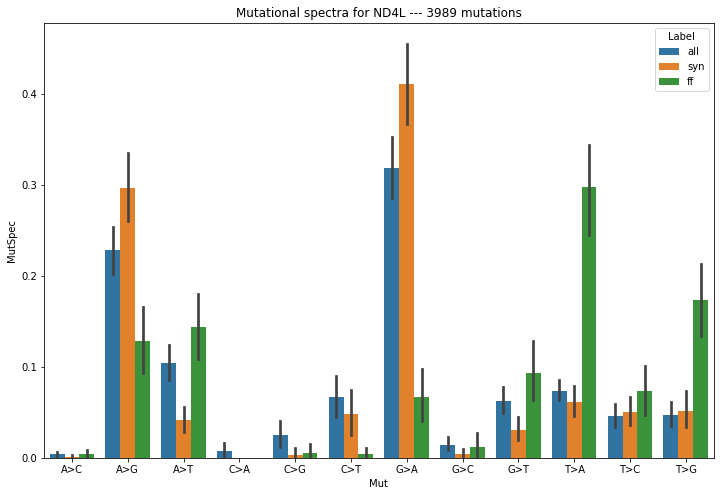

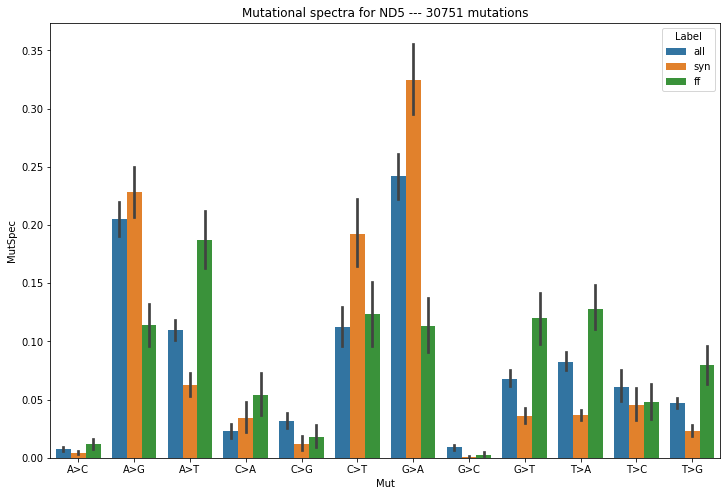

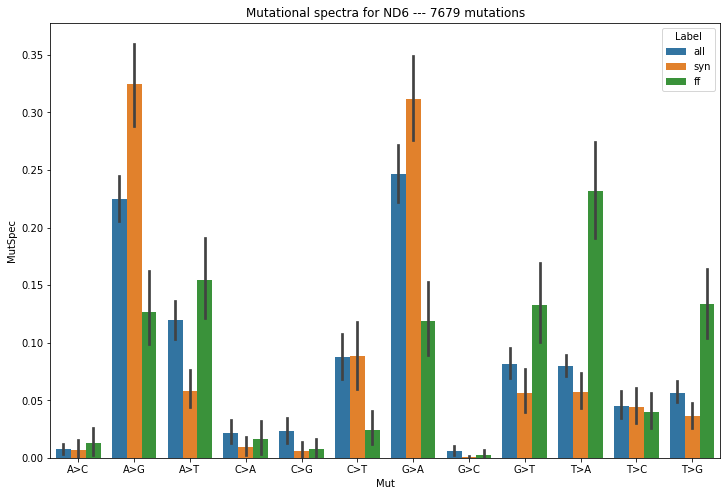

In [50]:
for gene in sorted(edge_mutspec12genes.Gene.unique()):
    ms = edge_mutspec12genes[edge_mutspec12genes.Gene == gene]
    mut_num = ms.ObsFr.sum()
    if mut_num > 50:
        plt.figure(figsize=(12, 8))
        sns.barplot(x="Mut", y="MutSpec", hue="Label", data=ms, order=possible_sbs12)
        plt.title(f"Mutational spectra for {id2gene[gene]} --- {mut_num} mutations")
        plt.show()